Folders ready: ../data/processed ../figures
Years to sample: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Sampling up to 5000 studies per year.

Fetching sampled trials for therapeutic area analysis...

Year 2015 done. Sampled 4994 trials (cumulative 4994).
Year 2016 done. Sampled 4993 trials (cumulative 9987).
Year 2017 done. Sampled 4990 trials (cumulative 14977).
Year 2018 done. Sampled 4993 trials (cumulative 19970).
Year 2019 done. Sampled 4989 trials (cumulative 24959).
Year 2020 done. Sampled 4993 trials (cumulative 29952).
Year 2021 done. Sampled 4996 trials (cumulative 34948).
Year 2022 done. Sampled 4989 trials (cumulative 39937).
Year 2023 done. Sampled 4992 trials (cumulative 44929).
Year 2024 done. Sampled 4991 trials (cumulative 49920).
Year 2025 done. Sampled 4987 trials (cumulative 54907).

Sample size by year:
2015    4994
2016    4993
2017    4990
2018    4993
2019    4989
2020    4993
2021    4996
2022    4989
2023    4992
2024    4991
2025    4

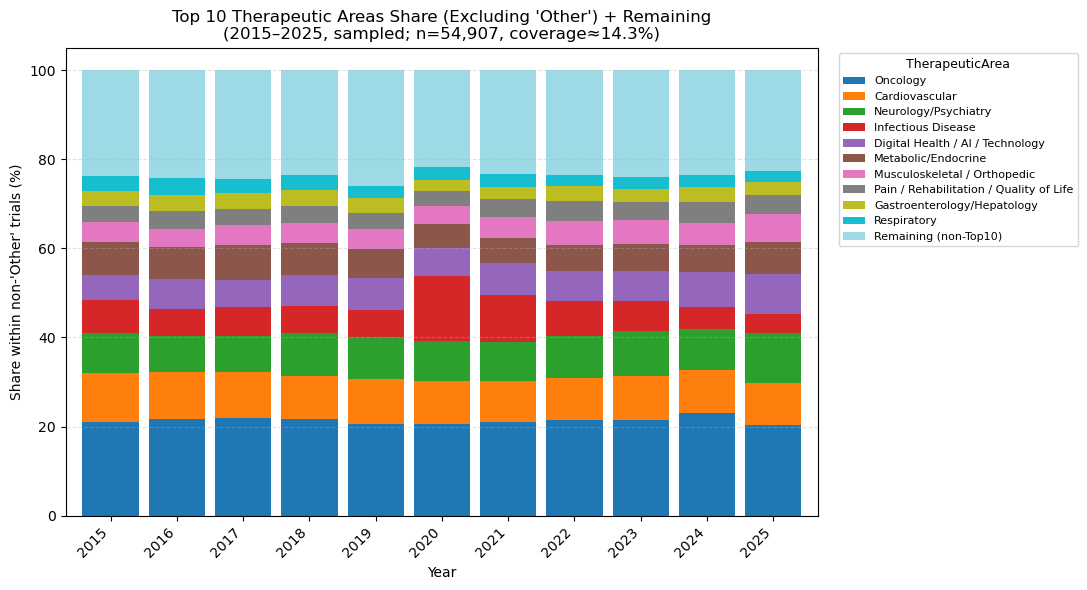

Saved Top 10 share figure to: ../figures/therapeutic_area_top10_share_2015_2025_sample_bar.png


In [7]:
"""
Module 3 — Therapeutic Area and Disease Focus (2015–2025, sampled)

Goal
-----
Fetch a sampled subset of newly posted trials (2015–2025) from ClinicalTrials.gov,
classify each trial into ONE therapeutic area using the `conditions` field, and
produce:
- Trial-level sample file
- Yearly counts and shares by therapeutic area (sample)
- Overall share table (sample)
- A cleaner Top-10 (excluding 'Other') + Remaining share (%) plot

Notes
-----
- This module uses sampling: per year fetch up to MAX_PAGES * PAGE_SIZE trials.
- Coverage (%) is computed against Module 1 totals *if available*.
  If the total-count file is missing, the plot will still render, and coverage will show as NA.
"""

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------
# Paths and base settings
# -------------------------------------------------------------------
BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
PROCESSED_DIR = "../data/processed"
FIG_DIR = "../figures"
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

YEARS = list(range(2015, 2026))  # 2015..2025

PAGE_SIZE = 500
MAX_PAGES = 10

print("Folders ready:", PROCESSED_DIR, FIG_DIR)
print("Years to sample:", YEARS)
print(f"Sampling up to {MAX_PAGES * PAGE_SIZE} studies per year.\n")

# -------------------------------------------------------------------
# Therapeutic area keyword dictionary
# (Keep your original dictionary exactly as you wrote it)
# -------------------------------------------------------------------
area_keywords = {
    "Oncology": [
        "cancer","tumor","tumour","carcinoma","lymphoma","leukemia","melanoma",
        "neoplasm","neoplasms","myeloma","sarcoma","metastatic","metastasis",
        "oncology","glioblastoma","glioma",
        "breast","lung","prostate","colorectal","ovarian","cervical",
        "endometrial","bladder","renal cell","pancreatic",
        "hematologic malignancy","haematologic malignancy","leukemic",
        "thoracic malignancy","chemotherapy","radiation therapy",
        "neuroblastoma","nsclc","t-all","myeloid malignancies","mcrc","crc"
    ],
    "Hematology / Blood Disorders": [
        "anemia","anaemia","iron-deficiency","iron deficiency",
        "hemoglobin","haemoglobin","hematologic","haematologic",
        "blood disorder","sickle cell","thalassemia","hemorrhage","haemorrhage",
        "transfusion","bleeding","hemostasis","coagulopathy","platelet",
        "thrombocytopenia","waldenstrom","amyloidosis","pnh",
        "myelofibrosis","hemophilia","mds ","aml ","cml ",
        "graft versus host","graft-versus-host","septicemia","septic shock"
    ],
    "Cardiovascular": [
        "heart","cardiac","hypertension","high blood pressure","blood pressure",
        "stroke","myocardial","coronary","artery","arterial","atrial",
        "fibrillation","heart failure","cardiomyopathy","vascular","angioplasty",
        "stent","thrombosis","ischemic","ischaemic","aneurysm","aortic aneurysm",
        "aortic valve","aortic stenosis","peripheral artery disease",
        "peripheral vascular disease","valve disease","mitral regurgitation",
        "mitral insufficiency","post-thrombotic syndrome"
    ],
    "Vascular / Peripheral Circulation": [
        "varicose","vein","venous","venous insufficiency","phlebitis",
        "deep vein thrombosis","dvt ","limb ischemia","peripheral arterial",
        "arteriopathy","peripheral circulation"
    ],
    "Metabolic/Endocrine": [
        "diabetes","diabetic","obesity","insulin","metabolic","metabolism",
        "glucose","thyroid","mellitus","lipid","cholesterol","hyperlipidemia",
        "dyslipidemia","hormone","endocrine","metabolic syndrome",
        "gout","hyperuricemia","uric acid","acromegaly","pituitary",
        "aldosteronism","primary aldosteronism","hypoglycemia","hypoglycaemia",
        "hyperkalemia","linear growth","pcos","polycystic ovary syndrome",
        "diabesity"
    ],
    "Infectious Disease": [
        "covid","sars-cov-2","virus","viral","infection","infectious","hiv","aids",
        "influenza","flu","bacterial","tuberculosis","tb ","hepatitis","pneumonia",
        "sepsis","malaria","parasite","parasitic","antiviral","antibiotic",
        "antimicrobial","candidiasis","vulvovaginal",
        "encephalitis","meningitis","encephalitis meningitis",
        "monkeypox","mpox","poxvirus","typhoid fever","pertussis","mrsa",
        "helminthiasis","chagas disease","hcv","hcc","cutaneous leishmaniasis"
    ],
    "Neurology/Psychiatry": [
        "alzheimer","dementia","parkinson","epilepsy","seizure","migraine",
        "headache","brain","neurologic","neurological","neuropathy",
        "multiple sclerosis"," ms ","bipolar","schizophrenia",
        "depression","depressive","depressive disorder","anxiety",
        "panic disorder","ptsd","post-traumatic stress","adhd",
        "attention deficit","autism","asperger","neurodevelopmental",
        "developmental disorder","cognition","cognitive","sleep disorder",
        "movement disorder","essential tremor","vestibular","vestibular disorder",
        "proprioception","memory impairment","dystonia","huntington",
        "myasthenia gravis","neuromyelitis optica","neurotoxicity",
        "psychosis","psychotic disorder","ocd","obsessive compulsive",
        "anorexia nervosa","bulimia nervosa","binge eating","eating disorder",
        "motor neuron disease","cerebral small vessel disease",
        "borderline personality disorder","personality disorder",
        "psychiatric disorder","mental disorder","psychological","aphasia"
    ],
    "Sleep / Fatigue / Circadian": [
        "sleep","sleep apnea","insomnia","circadian","circadian rhythm",
        "fatigue","daytime sleepiness","narcolepsy","sleep deprivation",
        "sleep quality","circadian rhythm disorders"
    ],
    "Behavioral / Psychological Health": [
        "somatic symptom","psychosomatic","stress","burnout","caregiver",
        "care-giver","behavior","behaviour","behavioral","behavioural",
        "lifestyle intervention","occupational","work-related","workload",
        "resilience","coping","well-being","wellbeing","mental health issue",
        "mental health","frailty","loneliness","communication",
        "family relations","patient compliance","medication adherence",
        "sick leave","whole health","development"
    ],
    "Substance Use / Addiction": [
        "substance use","substance use disorder","drug use","drug abuse",
        "opioid","opioid use","opioid use disorder","heroin",
        "methamphetamine","amphetamine","cocaine","cannabis","marijuana",
        "addiction","dependence","alcohol use","alcohol abuse","smoking",
        "nicotine","e-cig","e-cigarette","tobacco use","tobacco use disorder",
        "alcohol-related disorders","alcohol-related disorder",
        "alcohol withdrawal","pathological gambling","gambling disorder",
        "gambling problem","pji","lsd","acute cannabinoid intoxication"
    ],
    "Gastroenterology/Hepatology": [
        "liver","hepatic","hepatitis","stomach","gastric","gut","bowel",
        "gastro","gastrointestinal","gi tract","ulcer","crohn","colitis",
        "ibd ","pancreas","pancreatic","pancreatitis","necrotizing pancreatitis",
        "biliary","gallstone","ileus","intestinal obstruction",
        "postoperative ileus","constipation","bloating","gerd","reflux",
        "gastroesophageal reflux","dyspepsia","esophagitis","barrett",
        "anal fistula","hemorrhoid","hemorrhoids","perianal fistula",
        "eosinophilic esophagitis","cirrhosis","ascites",
        "achalasia","esophageal achalasia","dysphagia","presbyphagia",
        "colonic polyps","sclerosing cholangitis","cholangitis","osa"
    ],
    "Autoimmune/Inflammatory": [
        "arthritis","lupus","psoriasis","inflammatory","inflammation",
        "crohn","colitis","autoimmune","rheumatoid","sclerosis","sjogren",
        "vasculitis","myositis","polymyositis","dermatomyositis",
        "spondyloarthritis","rheumatic","familial mediterranean fever",
        "granulomatosis with polyangiitis","polyangiitis",
        "premalignant lesion","vitiligo","chondrocalcinosis"
    ],
    "Respiratory": [
        "asthma","asthmatic","copd","chronic obstructive pulmonary disease",
        "respiratory","pulmonary","bronchitis","lung disease",
        "respiratory distress","respiratory failure","oxygen","ventilation",
        "sleep apnea","cystic fibrosis","allergy","allergic","rhinitis",
        "sinusitis","nasal","thoracic diseases"
    ],
    "Musculoskeletal / Orthopedic": [
        "muscle","muscular","atrophy","dystrophy","neuromuscular","skeletal",
        "bone","orthopedic","orthopaedic","fracture","tendon","tendinopathy",
        "ligament","joint","cartilage","spine","back pain","low back pain",
        "flexor tendon","rotator cuff","hip","knee","shoulder","ankle",
        "hand surgery","foot surgery","patellar dislocation",
        "patellar instability","osteonecrosis","avascular necrosis",
        "disc herniation","herniated disc","disc displacement",
        "spinal stenosis","degenerative disc","spinal fusion",
        "spondylitis","ankylosing","arthroplasty","injuries",
        "spinal cord injury","spinal injury","paralysis","hallux valgus",
        "adhesive capsulitis","epicondylitis","limb deformities"
    ],
    "Pain / Rehabilitation / Quality of Life": [
        "pain","chronic pain","musculoskeletal pain","injury","rehabilitation",
        "recovery","rehab","trauma","fracture","spine","gait","mobility",
        "fatigue","function","functional status","physiotherapy",
        "physical therapy","exercise therapy","quality of life"," qol ",
        "well-being","wellbeing","palliative care","symptom management",
        "fibromyalgia","disability","falls","fear of falling","basic life support"
    ],
    "Sports / Exercise Medicine": [
        "exercise","exercise performance","exercise training","physical activity",
        "sports","sport","athlete","athletes","training","aerobic capacity",
        "performance","sports injury","fitness","resistance training",
        "endurance","strength training","young soccer players",
        "basket ball players","soccer players"
    ],
    "Digital Health / AI / Technology": [
        "digital health","ai","artificial intelligence","machine learning",
        "deep learning","technology","mobile health","mhealth","telemedicine",
        "telehealth","e-health","ehealth","wearable","sensor","app","software",
        "algorithm","automation","decision support","digital therapy",
        "virtual reality","vr","ar","scansys","computed tomography","ct "
    ],
    "Otolaryngology / ENT": [
        "hearing loss","hearing impairment","ear","otitis","tinnitus",
        "sinusitis","nasal polyp","nasal polyps","rhinosinusitis",
        "vocal cord","laryngeal","larynx","voice disorder","halitosis"
    ],
    "Nephrology / Urology": [
        "kidney","renal","nephro","nephritis","nephropathy","bladder",
        "urinary","urology","urothelial","incontinence","overactive bladder",
        "prostate","bph ","erectile","erectile dysfunction","sexual function",
        "urolithiasis","kidney stone","urinary stone","hemodialysis",
        "haemodialysis","dialysis","urogenital","sex development disorder",
        "urethritis","hypospadias","haemodiafiltration"
    ],
    "Reproductive / Obstetrics / Gynecology": [
        "pregnancy","pregnant","gestational","maternal","perinatal","fertility",
        "infertility","reproductive","birth","labor","labour","contraception",
        "ivf","in vitro fertilization","menopause","postmenopausal","post menopausal",
        "obstetric","preeclampsia","pre-eclampsia","placenta","uterus",
        "endometriosis","adenomyosis","cervix","vulvovaginal","gynecologic",
        "gynecological","vaginitis","female reproductive","women's health",
        "second trimester abortion","first trimester abortion",
        "menorrhagia","vaginal prolapse","fetal manual rotation",
        "menstruation","virginity"
    ],
    "Pediatrics": [
        "child","children","infant","infants","neonate","neonatal","newborn",
        "adolescent","teenager","teen","pediatric","paediatric",
        "intra uterine growth retardation","prenatal disorder",
        "child development","rett syndrome","spina bifida",
        "retinopathy of prematurity"
    ],
    "Geriatrics / Aging": [
        "aging","ageing","elderly","older adults","senior","geriatric",
        "frailty","long-term care","long term care","chronic illness",
        "fall prevention","old age; debility","middle aged patients"
    ],
    "Dermatology": [
        "skin","eczema","atopic dermatitis","dermatitis","psoriasis","acne",
        "rosacea","alopecia","wound","ulcer","pressure ulcer","bedsore","scar",
        "pruritus","itching","xerosis","xerosis cutis","keratosis",
        "hidradenitis","hidradenitis suppurativa","seborrheic","melasma",
        "epidermolysis bullosa","stretch mark","hyperhidrosis","cicatrix",
        "wrinkle","wrinkles","pemphigoid","bullous pemphigoid","vitiligo"
    ],
    "Ophthalmology": [
        "eye","ocular","retina","retinal","macular","maculopathy","glaucoma",
        "vision","visual","cataract","ophthalmic","keratoconus","myopia",
        "high myopia","aniridia","amblyopia","diabetic retinopathy"
    ],
    "Dental / Oral Health": [
        "dental","dentistry","tooth","teeth","oral","mouth","periodontal",
        "periodontitis","gingival","gingivitis","gingival recession",
        "root coverage","molar","third molar","wisdom tooth","orthodontic",
        "malocclusion","crowding","edentulous","edentulous jaw",
        "dentin","dentin hypersensitivity","caries","dental plaque",
        "necrotic pulp","pulpitis","irreversible pulpitis",
        "reversible pulpitis","endodontic disease","salivation","salivary"
    ],
    "Anesthesiology / Critical Care": [
        "anesthesia","anaesthesia","sedation","analgesia","intensive care",
        "icu","critical care","ventilation","mechanical ventilation",
        "airway","supraglottic airway","laryngeal mask","perioperative",
        "postoperative care","recovery room","sciatic nerve block",
        "endotracheal intubation","driving pressure","tracheostomy",
        "critical illness","emergence agitation","hypothermia"
    ],
    "Device / Diagnostic / Surgery": [
        "device","medical device","implant","stent","catheter","surgical",
        "surgery","laparoscopic","robotic","procedure","operation","endoscopy",
        "endoscopic","colonoscopy","gastroscopy","biopsy","prosthesis",
        "instrument","orthopedic surgery","spine surgery","joint replacement",
        "diagnostic","diagnostic value","imaging","ultrasound","mri","ct","pet ",
        "x-ray","sensor","monitoring","wearable","telemetry","hernia",
        "hernia repair","inguinal hernia","stoma","colostomy","appendicitis",
        "tracheostomy complications","total elbow replacement","nerve block"
    ],
    "Nutrition / Micronutrient": [
        "vitamin","vitamin a","vitamin d","vitamin b12","micronutrient",
        "nutritional deficiency","malnutrition","undernutrition","overnutrition",
        "salt","sodium","reducing salt","dietary salt","dietary intake",
        "dietary pattern","diet","nutrition","appetite","appetite regulation",
        "hydration","body fat","food supply","human milk","bottle feeding",
        "caffeine"
    ],
    "Public Health / Prevention": [
        "screening","screening program","vaccine","vaccination","prevent",
        "prevention","prophylaxis","public health","community health",
        "education","health education","behavior change","behaviour change",
        "smoking cessation","cohort studies","epidemiology","population health",
        "resource utilization","workflow","peer review","economic problems",
        "hospital acquired condition","hospitalization","organ donation",
        "teach-back communication","patient outcomes","whole health"
    ],
    "Rare Disease / Genetic": [
        "rare disease","orphan","genetic","mutation","inherited","hereditary",
        "gene therapy","monogenic","lysosomal","rare syndrome",
        "congenital disorder","rett syndrome","hypochondroplasia","xmen",
        "nf2","nf2 deficiency","fragile x syndrome","pompe disease",
        "phenylketonurias","osteochondrodysplasia",
        "fap-familial adenomatous polyposis","spina bifida"
    ],
    "General / Healthy Volunteers": [
        "healthy","healthy volunteer","healthy volunteers","healthy subjects",
        "healthy participants","healthy female volunteers",
        "healthy participants study","healthy control","normal volunteer",
        "normal subjects","safety study","first in human","tolerability",
        "dose escalation","phase 1 study in healthy"
    ],
}

def classify_area(text: str) -> str:
    """
    Return the first therapeutic area whose keyword appears in the text.
    If none match, return 'Other'.
    """
    if not isinstance(text, str):
        return "Other"
    t = text.lower()
    for area, kws in area_keywords.items():
        for k in kws:
            if k in t:
                return area
    return "Other"

# -------------------------------------------------------------------
# Step 1: Fetch sampled trials and keep ConditionText
# -------------------------------------------------------------------
records = []
print("Fetching sampled trials for therapeutic area analysis...\n")

for year in YEARS:
    start, end = f"{year}-01-01", f"{year}-12-31"
    page_token = None
    page_count = 0
    year_records_before = len(records)

    while page_count < MAX_PAGES:
        params = {
            "query.term": f"AREA[StudyFirstPostDate]RANGE[{start},{end}]",
            "pageSize": PAGE_SIZE,
            "format": "json",
        }
        if page_token:
            params["pageToken"] = page_token

        r = requests.get(BASE_URL, params=params, timeout=60)
        if r.status_code != 200:
            print(f"Year {year} HTTP error:", r.status_code)
            print(r.text[:300])
            break

        data = r.json()
        studies = data.get("studies", [])
        if not studies:
            break

        for s in studies:
            conds = (
                s.get("protocolSection", {})
                 .get("conditionsModule", {})
                 .get("conditions", [])
            )
            if not conds:
                continue

            text = " ".join(conds).lower()
            records.append({"Year": year, "ConditionText": text})

        page_token = data.get("nextPageToken")
        page_count += 1
        if not page_token:
            break

    year_added = len(records) - year_records_before
    print(f"Year {year} done. Sampled {year_added} trials (cumulative {len(records)}).")

df_conditions = pd.DataFrame(records)
print("\nSample size by year:")
print(df_conditions["Year"].value_counts().sort_index())

# -------------------------------------------------------------------
# Step 2: Classify into therapeutic areas
# -------------------------------------------------------------------
df_conditions["TherapeuticArea"] = df_conditions["ConditionText"].apply(classify_area)

print("\nTherapeutic area distribution (overall sample):")
print(df_conditions["TherapeuticArea"].value_counts())

# Save trial-level sample
sample_path = os.path.join(PROCESSED_DIR, "therapeutic_area_sample_2015_2025_full_years.csv")
df_conditions.to_csv(sample_path, index=False)
print("\nSaved classified sample to:", sample_path)

# -------------------------------------------------------------------
# Step 3: Aggregate by Year × TherapeuticArea (counts + shares)
# -------------------------------------------------------------------
agg_year_area = (
    df_conditions.groupby(["Year", "TherapeuticArea"]).size().reset_index(name="TrialCount")
)

years_full = list(range(2015, 2026))
pivot = (
    agg_year_area.pivot(index="Year", columns="TherapeuticArea", values="TrialCount")
    .reindex(years_full)
    .fillna(0)
)

share_year = pivot.div(pivot.sum(axis=1), axis=0) * 100.0

counts_path = os.path.join(PROCESSED_DIR, "therapeutic_area_counts_2015_2025_sample.csv")
shares_path = os.path.join(PROCESSED_DIR, "therapeutic_area_share_2015_2025_sample.csv")
agg_year_area.to_csv(counts_path, index=False)
share_year.to_csv(shares_path)

print("Saved yearly counts to:", counts_path)
print("Saved yearly shares to:", shares_path)

# -------------------------------------------------------------------
# Step 4: Overall distribution table (Count + % share)
# -------------------------------------------------------------------
total_n = len(df_conditions)
dist = df_conditions["TherapeuticArea"].value_counts()
share_pct = dist / total_n * 100

area_share_table = pd.DataFrame({
    "TherapeuticArea": dist.index,
    "Count": dist.values,
    "Share_pct": share_pct.round(2)
})

print("\nOverall therapeutic area distribution (count & share %):")
print(area_share_table.to_string(index=False))

overall_share_path = os.path.join(PROCESSED_DIR, "therapeutic_area_overall_share_2015_2025_sample.csv")
area_share_table.to_csv(overall_share_path, index=False)
print("\nSaved overall share table to:", overall_share_path)

# -------------------------------------------------------------------
# Step 5 (REVISED): Stacked bar — Top 10 (excluding 'Other') + Remaining
# Title includes sample coverage %
# -------------------------------------------------------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

total_n = len(df_conditions)

# --- Compute sample coverage (%) using Module 1 totals ---
tot_path = os.path.join(PROCESSED_DIR, "global_trials_totalcount_by_year_2015_2025.csv")
if not os.path.exists(tot_path):
    raise FileNotFoundError(
        f"Cannot find Module 1 output: {tot_path}\n"
        "Please run Module 1 first, or check your PROCESSED_DIR / working directory."
    )

df_tot = pd.read_csv(tot_path)
df_tot_15_25 = df_tot.query("Year >= 2015 & Year <= 2025")

if "TrialCount" not in df_tot_15_25.columns or df_tot_15_25["TrialCount"].sum() == 0:
    raise ValueError("Module 1 totals look invalid: TrialCount missing or sum == 0.")

total_population = int(df_tot_15_25["TrialCount"].sum())
coverage_pct = 100.0 * total_n / total_population

# --- Exclude 'Other' and build Year x Area counts ---
df_non_other = df_conditions[df_conditions["TherapeuticArea"] != "Other"].copy()

agg_non_other = (
    df_non_other.groupby(["Year", "TherapeuticArea"])
    .size()
    .reset_index(name="TrialCount")
)

years_full = list(range(2015, 2026))
pivot_non_other = (
    agg_non_other.pivot(index="Year", columns="TherapeuticArea", values="TrialCount")
    .reindex(years_full)
    .fillna(0)
)

# Share within non-'Other' each year (%)
share_non_other = pivot_non_other.div(pivot_non_other.sum(axis=1), axis=0) * 100.0

# Top 10 areas by total volume (excluding Other)
top10 = pivot_non_other.sum(axis=0).sort_values(ascending=False).head(10).index.tolist()

share_top10 = share_non_other[top10].copy()
share_top10["Remaining (non-Top10)"] = 100.0 - share_top10.sum(axis=1)
share_top10["Remaining (non-Top10)"] = share_top10["Remaining (non-Top10)"].clip(lower=0)

# --- Plot: stacked bar ---
fig, ax = plt.subplots(figsize=(11, 6))

n_series = share_top10.shape[1]
cmap = plt.colormaps.get_cmap("tab20").resampled(n_series)
colors = [cmap(i) for i in range(n_series)]

share_top10.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    width=0.85,
    color=colors,
    edgecolor="none"
)

ax.set_title(
    "Top 10 Therapeutic Areas Share (Excluding 'Other') + Remaining\n"
    f"(2015–2025, sampled; n={total_n:,}, coverage≈{coverage_pct:.1f}%)",
    fontsize=12
)
ax.set_xlabel("Year")
ax.set_ylabel("Share within non-'Other' trials (%)")
ax.grid(True, axis="y", linestyle="--", alpha=0.35)

ax.set_xticklabels([str(y) for y in years_full], rotation=45, ha="right")

ax.legend(
    title="TherapeuticArea",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()

fig_path = os.path.join(FIG_DIR, "therapeutic_area_top10_share_2015_2025_sample_bar.png")
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved Top 10 share figure to:", fig_path)



Sampled trials: 54,907
Total trials (2015–2025): 382,630
Coverage ≈ 14.35% of all trials
Excluded 'Other': 4,925 trials
Non-'Other' sample size: 49,982


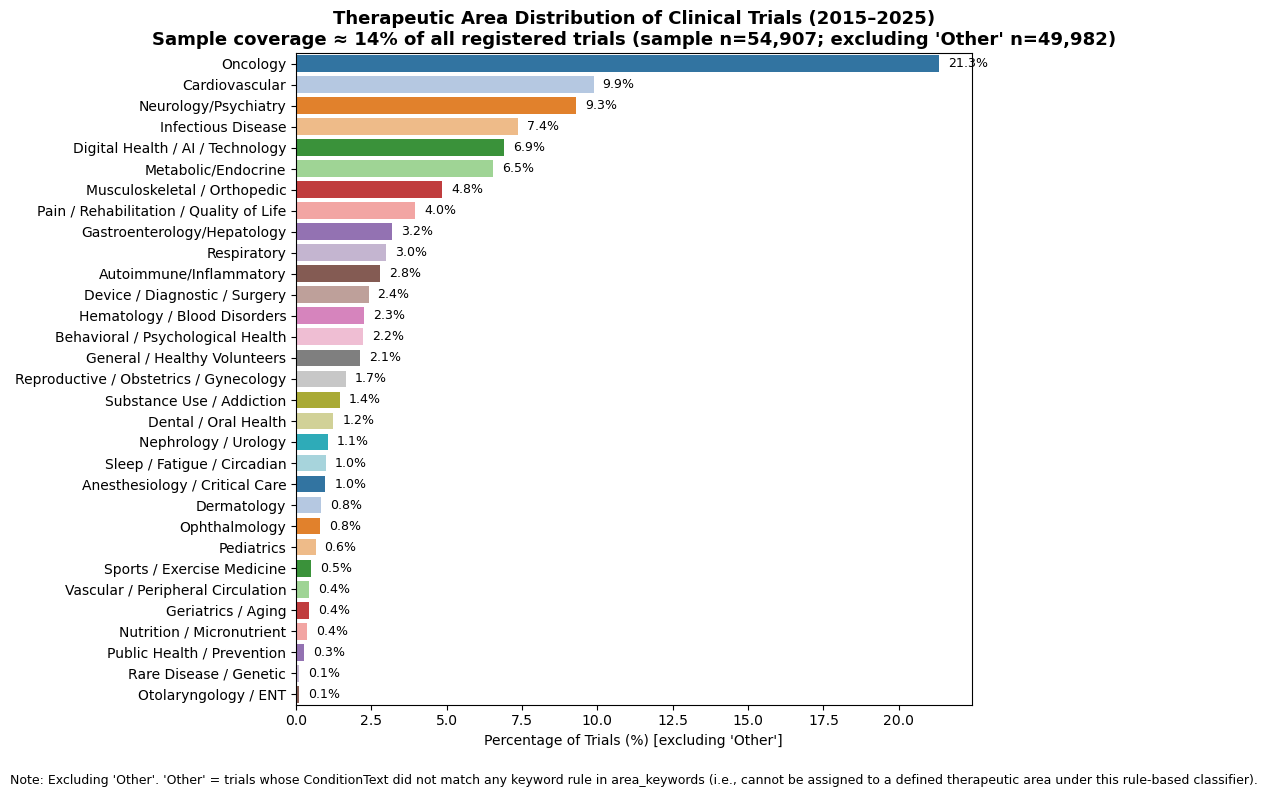

In [9]:
# ============================================================
# MODULE 3 — Final Visualization: Therapeutic Area Distribution (2015–2025) [Excluding "Other"]
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---- 1. Compute coverage based on Module 1 total trial count ----
total_sampled = len(df_conditions)

df_tot = pd.read_csv("../data/processed/global_trials_totalcount_by_year_2015_2025.csv")
df_tot_15_25 = df_tot.query("Year >= 2015 & Year <= 2025")
total_population = df_tot_15_25["TrialCount"].sum()

coverage_pct = 100 * total_sampled / total_population
coverage_rounded = round(coverage_pct)

print(f"Sampled trials: {total_sampled:,}")
print(f"Total trials (2015–2025): {total_population:,}")
print(f"Coverage ≈ {coverage_pct:.2f}% of all trials")

# ---- 2. Compute area distribution (EXCLUDING 'Other') ----
# Excluding "Other" means:
# "Other" = trials whose ConditionText did NOT match any keyword rule in area_keywords,
# so they cannot be confidently assigned to a defined therapeutic area in this rule-based scheme.
df_no_other = df_conditions[df_conditions["TherapeuticArea"] != "Other"].copy()
n_no_other = len(df_no_other)

area_counts = df_no_other["TherapeuticArea"].value_counts()
area_df = (
    area_counts.rename_axis("TherapeuticArea")
    .reset_index(name="TrialCount")
)
area_df["Share(%)"] = 100 * area_df["TrialCount"] / n_no_other

print(f"Excluded 'Other': {total_sampled - n_no_other:,} trials")
print(f"Non-'Other' sample size: {n_no_other:,}")

# ---- 3. Plot ----
fig, ax = plt.subplots(figsize=(10, 8))

colors = sns.color_palette("tab20", n_colors=len(area_df))
sns.barplot(
    data=area_df,
    x="Share(%)",
    y="TherapeuticArea",
    palette=colors,
    ax=ax
)

# Add percentage labels
for i, share in enumerate(area_df["Share(%)"]):
    ax.text(share + 0.3, i, f"{share:.1f}%", va="center", fontsize=9)

# ---- 4. Title ----
title = (
    "Therapeutic Area Distribution of Clinical Trials (2015–2025)\n"
    f"Sample coverage ≈ {coverage_rounded}% of all registered trials "
    f"(sample n={total_sampled:,}; excluding 'Other' n={n_no_other:,})"
)
ax.set_title(title, fontsize=13, weight="bold")
ax.set_xlabel("Percentage of Trials (%) [excluding 'Other']")
ax.set_ylabel("")

# ---- 5. Footnote (note about excluding Other + definition) ----
footnote = (
    "Note: Excluding 'Other'. "
    "'Other' = trials whose ConditionText did not match any keyword rule in area_keywords "
    "(i.e., cannot be assigned to a defined therapeutic area under this rule-based classifier)."
)
fig.text(0.01, 0.01, footnote, ha="left", va="bottom", fontsize=9)

plt.tight_layout(rect=[0, 0.04, 1, 1])  # leave space at bottom for footnote
plt.show()